# Bias correction - empirical distribution mapping

## Author: Anna Vaughan

Demonstrates how to bias correct data using detrended quantile mapping (DQM)

In [1]:
import xarray
from matplotlib import pyplot as plt 
from scipy.signal import detrend
import warnings
import numpy as np
warnings.filterwarnings('ignore')

$\hat{x}_{m, p}(t) = F_{o, h}^{-1}(F_{m, h}[\frac{\bar{x}_{m, h}x_{m, p}(t)}{\bar{x}_{m, p}(t)}])\frac{\bar{x}_{m, p}(t)}{\bar{x}_{m, h}}$

p = projected

h = historical

m = model

o = observed

In [2]:
from statsmodels.distributions.empirical_distribution import ECDF

ImportError: No module named 'statsmodels'

In [91]:
rcp_45_data = xarray.open_dataarray('Beijing_rcp45.nc')
rcp_85_data = xarray.open_dataarray('Beijing_rcp85.nc')
obs_data = xarray.open_dataarray('Beijing_ERAI.nc')

In [92]:
def ecdf_bias_correction(model, obs, ref_times, future_times):
    
    # Subset past and future
    ref_times = ('2000-01-01', '2009-12-31')
    future_times = ('2030-01-01', '2039-12-31')

    model_h = model.sel(time=slice(*ref_times)).values
    model_p = model.sel(time=slice(*future_times)).values
    obs_h = obs.sel(time=slice(*ref_times)).values
    
    # Construct ECDF for historical model times
    ecdf_m_h = ECDF(model_h)

    # Find x_{m, h} mean
    mu_m_h = model_h.mean()

    # Find x_{m, p} mean
    mu_m_p = model_p.mean()
    
    r1 = mu_m_h/mu_m_p
    r2 = mu_m_p/mu_m_h

    corrected = [np.quantile(obs_h, (ecdf_m_h(r1*val)))*r2
                     for val in model_p]
    return(corrected)

In [106]:
ref_times = ('1980-01-01', '1989-12-31')
future_times = ('2030-01-01', '2039-12-31')
bias_corrected = ecdf_bias_correction(rcp_45_data, obs_data, ref_times, future_times)

In [107]:
from scipy.stats.kde import gaussian_kde

In [108]:
model = rcp_85_data
obs = obs_data
model_h = model.sel(time=slice(*ref_times)).values
model_p = model.sel(time=slice(*future_times)).values
obs_h = obs.sel(time=slice(*ref_times)).values
bias_corrected = ecdf_bias_correction(rcp_85_data, obs_data, ref_times, future_times)

In [109]:
obs_kde = gaussian_kde(obs_h)
model_h_kde = gaussian_kde(model_h)
model_p_kde = gaussian_kde(model_p)
bc_kde = gaussian_kde(bias_corrected)

dist_space = np.linspace(250, 330, 250 )

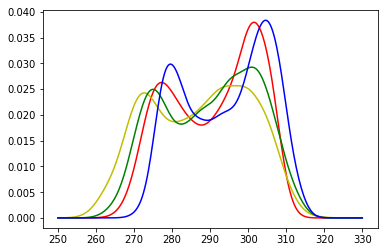

In [110]:
plt.plot(dist_space, obs_kde(dist_space), "r")
plt.plot(dist_space, model_h_kde(dist_space), "y")

plt.plot(dist_space, model_p_kde(dist_space), "g")
plt.plot(dist_space, bc_kde(dist_space), "b")
plt.show()